# 실생활 예제로 PINNs 학습하기

## 문제 설명: 전염병 확산 예측 (SIR 모델)

SIR 모델은 전염병 확산을 예측하기 위한 수학적 모델입니다. 다음 방정식으로 표현됩니다:

$$
\begin{aligned}
\frac{dS}{dt} &= -\beta S I, \\
\frac{dI}{dt} &= \beta S I - \gamma I, \\
\frac{dR}{dt} &= \gamma I.
\end{aligned}
$$

여기서:
$$
\begin{aligned}
& S : \text{감염 가능 인구} \\
& I : \text{감염된 인구} \\
& R : \text{회복된 인구} \\
& \beta : \text{감염률} \\
& \gamma : \text{회복률}
\end{aligned}
$$

초기 조건:
$$
S(0) = S_0, \ I(0) = I_0, \ R(0) = 0.
$$

---

```python
# 필요한 라이브러리 불러오기
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
```

---

## SIR 모델 PINN 정의

```python
# PINN 모델 정의
class PINN_SIR(nn.Module):
    def __init__(self):
        super(PINN_SIR, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 3)  # S, I, R 3개의 출력
        )

    def forward(self, x):
        return self.layers(x)
```

---

## 손실 함수 정의

```python
# 손실 함수 정의
# 초기 조건과 방정식을 함께 고려한 손실 함수

def loss_sir(model, t, beta, gamma, S0, I0, R0):
    t.requires_grad = True
    output = model(t)
    S, I, R = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    dS_dt = torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0]
    dI_dt = torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
    dR_dt = torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0]

    # 방정식 손실
    eq1 = dS_dt + beta * S * I
    eq2 = dI_dt - beta * S * I + gamma * I
    eq3 = dR_dt - gamma * I

    # 초기 조건 손실 (t=0에서의 값 사용)
    t0 = torch.tensor([[0.0]], requires_grad=True)
    output_t0 = model(t0)
    S0_pred, I0_pred, R0_pred = output_t0[0, 0], output_t0[0, 1], output_t0[0, 2]

    ic_loss = (S0_pred - S0)**2 + (I0_pred - I0)**2 + (R0_pred - R0)**2

    # 총 손실
    loss = torch.mean(eq1**2) + torch.mean(eq2**2) + torch.mean(eq3**2) + ic_loss
    return loss
```

---

## 모델 학습 함수

```python
# 모델 학습 함수
def train_sir_model(model, t_train, loss_fn, beta, gamma, S0, I0, R0, epochs=1000, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t_train, beta, gamma, S0, I0, R0)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
```

---

## 학습 및 결과 시각화

```python
# 초기 조건 및 매개변수 설정
S0, I0, R0 = 0.99, 0.1, 0.0  # 초기 인구 비율
beta, gamma = 0.3, 0.1        # 감염률과 회복률

# 학습 데이터 생성
t_train = torch.linspace(0, 20, 100).view(-1, 1)  # 0일부터 20일까지

# PINN 모델 학습
model_sir = PINN_SIR()
train_sir_model(model_sir, t_train, loss_sir, beta, gamma, S0, I0, R0, epochs=10000)

# 결과 시각화
t_test = np.linspace(0, 20, 100)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32).view(-1, 1)
output = model_sir(t_test_tensor).detach().numpy()
S_pred, I_pred, R_pred = output[:, 0], output[:, 1], output[:, 2]

plt.plot(t_test, S_pred, label="Susceptible")
plt.plot(t_test, I_pred, label="Infected")
plt.plot(t_test, R_pred, label="Recovered")
plt.title("SIR Model Prediction")
plt.xlabel("Time (days)")
plt.ylabel("Population Fraction")
plt.legend()
plt.show()
```

---

## 추가: 정확한 해와 비교

```python
# SIR 모델의 정확한 해 계산
def sir_exact_solution(beta, gamma, S0, I0, t):
    from scipy.integrate import solve_ivp

    def sir_ode(t, y):
        S, I, R = y
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I
        return [dS_dt, dI_dt, dR_dt]

    sol = solve_ivp(sir_ode, [0, max(t)], [S0, I0, 0], t_eval=t)
    return sol.y

# 정확한 해 계산
exact_solution = sir_exact_solution(beta, gamma, S0, I0, t_test)
S_exact, I_exact, R_exact = exact_solution

# PINN 예측과 정확한 해 비교
plt.plot(t_test, S_pred, 'b--', label="PINN Susceptible")
plt.plot(t_test, I_pred, 'r--', label="PINN Infected")
plt.plot(t_test, R_pred, 'g--', label="PINN Recovered")

plt.plot(t_test, S_exact, 'b-', label="Exact Susceptible")
plt.plot(t_test, I_exact, 'r-', label="Exact Infected")
plt.plot(t_test, R_exact, 'g-', label="Exact Recovered")

plt.title("SIR Model: PINN vs Exact Solution")
plt.xlabel("Time (days)")
plt.ylabel("Population Fraction")
plt.legend()
plt.show()
```


In [ ]:
# 필요한 라이브러리 불러오기
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
# PINN 모델 정의
class PINN_SIR(nn.Module):
    def __init__(self):
        super(PINN_SIR, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 3)  # S, I, R 3개의 출력
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# 손실 함수 정의
# 초기 조건과 방정식을 함께 고려한 손실 함수

def loss_sir(model, t, beta, gamma, S0, I0, R0):
    t.requires_grad = True
    output = model(t)
    S, I, R = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    dS_dt = torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0]
    dI_dt = torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
    dR_dt = torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0]

    # 방정식 손실
    eq1 = dS_dt + beta * S * I
    eq2 = dI_dt - beta * S * I + gamma * I
    eq3 = dR_dt - gamma * I

    # 초기 조건 손실 (t=0에서의 값 사용)
    t0 = torch.tensor([[0.0]], requires_grad=True)
    output_t0 = model(t0)
    S0_pred, I0_pred, R0_pred = output_t0[0, 0], output_t0[0, 1], output_t0[0, 2]

    ic_loss = (S0_pred - S0)**2 + (I0_pred - I0)**2 + (R0_pred - R0)**2

    # 총 손실
    loss = torch.mean(eq1**2) + torch.mean(eq2**2) + torch.mean(eq3**2) + ic_loss
    return loss

In [ ]:
# 모델 학습 함수
def train_sir_model(model, t_train, loss_fn, beta, gamma, S0, I0, R0, epochs=1000, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t_train, beta, gamma, S0, I0, R0)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.8760
Epoch 100, Loss: 0.0002
Epoch 200, Loss: 0.0002
Epoch 300, Loss: 0.0002
Epoch 400, Loss: 0.0002
Epoch 500, Loss: 0.0002
Epoch 600, Loss: 0.0007
Epoch 700, Loss: 0.0002
Epoch 800, Loss: 0.0002
Epoch 900, Loss: 0.0002
Epoch 1000, Loss: 0.0001
Epoch 1100, Loss: 0.0001
Epoch 1200, Loss: 0.0006
Epoch 1300, Loss: 0.0000
Epoch 1400, Loss: 0.0000
Epoch 1500, Loss: 0.0000
Epoch 1600, Loss: 0.0000
Epoch 1700, Loss: 0.0000
Epoch 1800, Loss: 0.0000
Epoch 1900, Loss: 0.0000
Epoch 2000, Loss: 0.0000
Epoch 2100, Loss: 0.0001
Epoch 2200, Loss: 0.0000
Epoch 2300, Loss: 0.0000
Epoch 2400, Loss: 0.0000
Epoch 2500, Loss: 0.0000
Epoch 2600, Loss: 0.0000
Epoch 2700, Loss: 0.0000
Epoch 2800, Loss: 0.0000
Epoch 2900, Loss: 0.0000
Epoch 3000, Loss: 0.0000
Epoch 3100, Loss: 0.0000
Epoch 3200, Loss: 0.0000
Epoch 3300, Loss: 0.0000
Epoch 3400, Loss: 0.0000
Epoch 3500, Loss: 0.0000
Epoch 3600, Loss: 0.0000
Epoch 3700, Loss: 0.0000
Epoch 3800, Loss: 0.0000
Epoch 3900, Loss: 0.0000
Epoch 4000, 

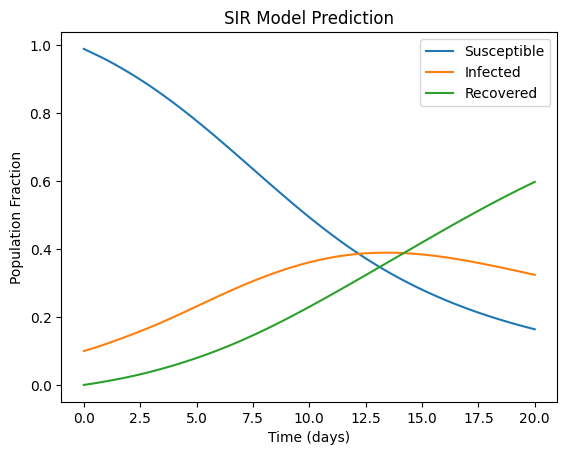

In [ ]:
# 초기 조건 및 매개변수 설정
S0, I0, R0 = 0.99, 0.1, 0.0  # 초기 인구 비율
beta, gamma = 0.3, 0.1        # 감염률과 회복률

# 학습 데이터 생성
t_train = torch.linspace(0, 20, 100).view(-1, 1)  # 0일부터 20일까지

# PINN 모델 학습
model_sir = PINN_SIR()
train_sir_model(model_sir, t_train, loss_sir, beta, gamma, S0, I0, R0, epochs=10000)

# 결과 시각화
t_test = np.linspace(0, 20, 100)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32).view(-1, 1)
output = model_sir(t_test_tensor).detach().numpy()
S_pred, I_pred, R_pred = output[:, 0], output[:, 1], output[:, 2]

plt.plot(t_test, S_pred, label="Susceptible")
plt.plot(t_test, I_pred, label="Infected")
plt.plot(t_test, R_pred, label="Recovered")
plt.title("SIR Model Prediction")
plt.xlabel("Time (days)")
plt.ylabel("Population Fraction")
plt.legend()
plt.show()

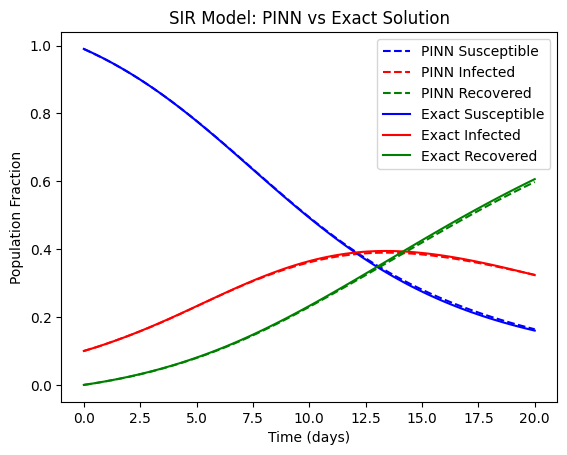

In [ ]:
# SIR 모델의 정확한 해 계산
def sir_exact_solution(beta, gamma, S0, I0, t):
    from scipy.integrate import solve_ivp

    def sir_ode(t, y):
        S, I, R = y
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I
        return [dS_dt, dI_dt, dR_dt]

    sol = solve_ivp(sir_ode, [0, max(t)], [S0, I0, 0], t_eval=t)
    return sol.y


# 정확한 해 계산
exact_solution = sir_exact_solution(beta, gamma, S0, I0, t_test)
S_exact, I_exact, R_exact = exact_solution

# PINN 예측과 정확한 해 비교
plt.plot(t_test, S_pred, 'b--', label="PINN Susceptible")
plt.plot(t_test, I_pred, 'r--', label="PINN Infected")
plt.plot(t_test, R_pred, 'g--', label="PINN Recovered")

plt.plot(t_test, S_exact, 'b-', label="Exact Susceptible")
plt.plot(t_test, I_exact, 'r-', label="Exact Infected")
plt.plot(t_test, R_exact, 'g-', label="Exact Recovered")

plt.title("SIR Model: PINN vs Exact Solution")
plt.xlabel("Time (days)")
plt.ylabel("Population Fraction")
plt.legend()
plt.show()